In [1]:
import mediapy as media
import mujoco
import numpy as np


def check_joint_limits(model, q, ids):
        """Check if the joints is under or above its limits"""
        for i in range(len(q)):
            id = ids[i]
            q[i] = max(
                model.jnt_range[id][0], min(q[i], model.jnt_range[id][1])
            )

class GradientDescentIK:
    def __init__(self, model, data, step_size, tol, alpha, jacp, jacr):
        self.model = model
        self.data = data
        self.step_size = step_size
        self.tol = tol
        self.alpha = alpha
        self.jacp = jacp
        self.jacr = jacr

    # Gradient Descent pseudocode implementation
    def calculate(self, goal, init_q, body_id, prosthesis_ids, max_steps=5000):
        """Calculate the desire joints angles for goal"""
        assert len(init_q) == len(prosthesis_ids)
        self.data.qpos[prosthesis_ids] = init_q
        mujoco.mj_forward(self.model, self.data)
        current_pose = self.data.body(body_id).xpos
        error = np.subtract(goal, current_pose)
        step = 0
        while np.linalg.norm(error) >= self.tol:
            print(f"Step: {step} | Error: {np.linalg.norm(error)}")
            step += 1
            # calculate jacobian
            mujoco.mj_jac(self.model, self.data, self.jacp, self.jacr, goal, body_id)
            # calculate gradient
            grad = self.alpha * self.jacp.T @ error
            # compute next step
            self.data.qpos[prosthesis_ids] += self.step_size * grad[prosthesis_ids]
            # check joint limits
            check_joint_limits(self.model, self.data.qpos[prosthesis_ids], prosthesis_ids)
            # compute forward kinematics
            mujoco.mj_forward(self.model, self.data)
            # calculate new error
            error = np.subtract(goal, self.data.body(body_id).xpos)

            if step >= max_steps:
                break

        return self.data.qpos[prosthesis_ids].copy()

Initial point => [0.19447446 0.06381425 0.85790345]
Target point => [ 0.31731241 -0.24660306  1.01223091] 



Initial position,Desire end effector position

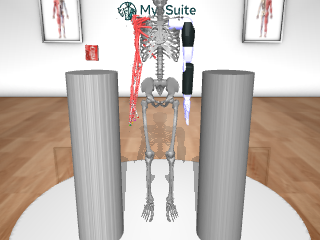
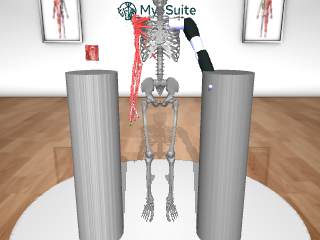

In [2]:
xml = "/home/kai/code/MBSyn2/.venv/lib/python3.10/site-packages/myosuite/envs/myo/assets/arm/myoarm_bionic_bimanual.xml"
model = mujoco.MjModel.from_xml_path(xml)
data = mujoco.MjData(model)
eef_name = "prosthesis/palm"

obj_id = 64
# prosthesis_ids = list(range(38, 45))
prosthesis_ids = list(range(38, 42))

renderer = mujoco.Renderer(model)
camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 1

# Get initial point
data.qpos[:obj_id] = [0 for _ in range(obj_id)]
mujoco.mj_forward(model, data)
init_point = data.body(eef_name).xpos.copy()
qpos0 = data.qpos.copy()
renderer.update_scene(data, camera)
target_plot = renderer.render()

# Get desire point
data.qpos[prosthesis_ids] += np.random.randn(len(prosthesis_ids)) * 0.5
check_joint_limits(model, data.qpos[prosthesis_ids], prosthesis_ids)
mujoco.mj_forward(model, data)
target_qpos = data.qpos.copy()
target = data.body(eef_name).xpos.copy()
renderer.update_scene(data, camera)
result_plot = renderer.render()
print("Initial point =>", init_point)
print("Target point =>", target, "\n")

images = {
    "Initial position": target_plot,
    " Desire end effector position": result_plot,
}

media.show_images(images)

Step: 0 | Error: 0.3733748022399555
Step: 1 | Error: 0.3469595642038598
Step: 2 | Error: 0.3219373394392317
Step: 3 | Error: 0.29834154130319246
Step: 4 | Error: 0.2761779149599532
Step: 5 | Error: 0.25542964557341896
Step: 6 | Error: 0.23606223232174803
Step: 7 | Error: 0.21802790162609553
Step: 8 | Error: 0.20126944135412145
Step: 9 | Error: 0.18572341898988143
Step: 10 | Error: 0.1713228019528781
Step: 11 | Error: 0.15799903161955
Step: 12 | Error: 0.14568361939991945
Step: 13 | Error: 0.13430933846882073
Step: 14 | Error: 0.1238110826271533
Step: 15 | Error: 0.11412645744670186
Step: 16 | Error: 0.10519616056146541
Step: 17 | Error: 0.0969641991645579
Step: 18 | Error: 0.08937798432607202
Step: 19 | Error: 0.08238833412904753
Step: 20 | Error: 0.07594941102388841
Step: 21 | Error: 0.07001861325647495
Step: 22 | Error: 0.0645564356683184
Step: 23 | Error: 0.059526311488773104
Step: 24 | Error: 0.05489444381364042
Step: 25 | Error: 0.05062963316647106
Step: 26 | Error: 0.046703105753

Initial position,Target position,Gradient Descent result

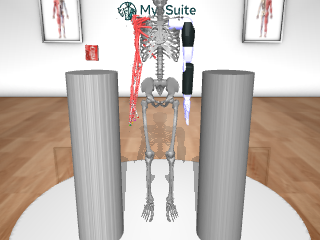
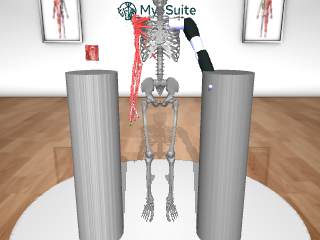
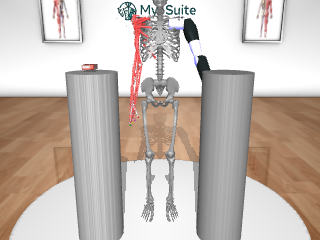

In [3]:
# Init variables.
body_id = model.body(eef_name).id
jacp = np.zeros((3, model.nv))  # translation jacobian
jacr = np.zeros((3, model.nv))  # rotational jacobian
goal = target
step_size = 0.5
tol = 0.03
alpha = 0.5

ik = GradientDescentIK(model, data, step_size, tol, alpha, jacp, jacr)

# Get desire point
mujoco.mj_resetDataKeyframe(model, data, 1)  # reset qpos to initial value
ik.calculate(goal, qpos0.copy()[prosthesis_ids], body_id, prosthesis_ids)  # calculate the q angles

result = ik.data.qpos.copy()

data.qpos = qpos0
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
init_plot = renderer.render()

data.qpos = target_qpos
mujoco.mj_forward(model, data)
renderer.update_scene(data, camera)
target_plot = renderer.render()

data.qpos = result
mujoco.mj_forward(model, data)
result_point = data.body(eef_name).xpos.copy()
renderer.update_scene(data, camera)
result_plot = renderer.render()

print("Initial point =>", init_point)
print("Target point =>", target)
print("Gradient Descent result =>", result_point, "\n")

images = {
    "Initial position": init_plot,
    "Target position": target_plot,
    "Gradient Descent result": result_plot,
}

media.show_images(images)

In [4]:
from IPython.display import HTML
from base64 import b64encode
 
def show_video(video_path, video_width = 400):
   
  video_file = open(video_path, "r+b").read()
 
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video autoplay width={video_width} controls><source src="{video_url}"></video>""")
 

In [5]:
from pathlib import Path
from myosuite.utils import gym
import skvideo.io
import numpy as np
env = gym.make('myoChallengeBimanual-v0', normalize_act=False)
env.reset()
obs_dict = env.get_obs_dict(env.sim)
goal_pos = obs_dict['goal_pos']
goal_pos[2] += 0.2
init_qpos = obs_dict['pros_hand_qpos'][:len(prosthesis_ids)]
target_qpos = ik.calculate(goal_pos, init_qpos.copy(), body_id, prosthesis_ids)
frames = []
for _ in range(100):
    frame = env.sim.renderer.render_offscreen(
                        width=400,
                        height=400,
                        camera_id=0)
    frames.append(frame)
    action = env.action_space.sample()
    action[63:67] = target_qpos
    env.step(action)
env.close()
Path('videos').mkdir(exist_ok=True)
# make a local copy
skvideo.io.vwrite('videos/temp.mp4', np.asarray(frames),outputdict={"-pix_fmt": "yuv420p"})
# show in the notebook
show_video('videos/temp.mp4')

MyoSuite:> Registering Myo Envs
    MyoSuite: A contact-rich simulation suite for musculoskeletal motor control
        Vittorio Caggiano, Huawei Wang, Guillaume Durandau, Massimo Sartori, Vikash Kumar
        L4DC-2019 | https://sites.google.com/view/myosuite
    


/home/kai/code/MBSyn2/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.get_obs_dict to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_obs_dict` for environment variables or `env.get_wrapper_attr('get_obs_dict')` that will search the reminding wrappers.
  logger.warn(
/home/kai/code/MBSyn2/.venv/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.sim to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.sim` for environment variables or `env.get_wrapper_attr('sim')` that will search the reminding wrappers.
  logger.warn(
/home/kai/code/MBSyn2/.venv/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:159: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
